In [1]:
import os
import yaml
from scipy.special import expit
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from regionmask import mask_geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo

plt.rcParams["font.family"] = "monospace" #

wd = "hazGAN2/projects/poweruk_winter"

with open(os.path.join(wd, "config.yaml"), "r") as stream:
    config = yaml.safe_load(stream)

regions = ["East Midlands", "West Midlands", "South West England", "South Wales"]
region_of_interest = regions[0]

season = config["sfunc"]
local_crs = config["local_crs"]


datasets = ["training", "generated"]

training = xr.open_dataset(os.path.join(
    wd, "analysis", "data", f"risk_profile_{region_of_interest.lower()}_training_{season}.nc")
)

generated = xr.open_dataset(os.path.join(
    wd, "analysis", "data", f"risk_profile_{region_of_interest.lower()}_generated_{season}.nc")
)

ERROR 1: PROJ: proj_create_from_database: Open of /hn01-home/spet5107/micromamba/envs/hazGAN/share/proj failed


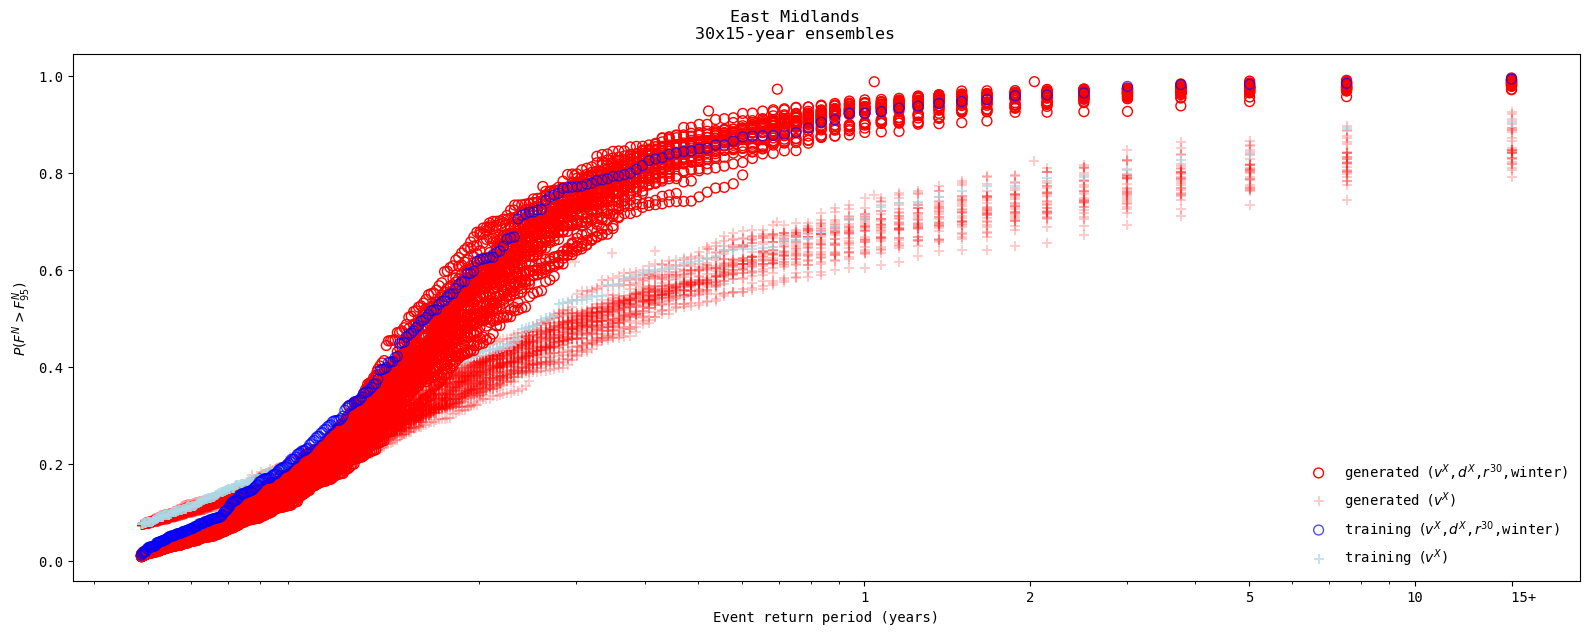

In [8]:
fig, ax = plt.subplots(1, figsize=(16, 6))

gen_ensembles = generated.attrs["n_ensembles"]
ensemble_years = generated.attrs["ensemble_years"]
rp_max = generated.attrs["rp_max"]

generated.plot.scatter(x="return_period", y="outage_prob", ax=ax, edgecolor="red", color="none",
                      s=50, zorder=1, marker='o', label=fr"generated $(v^X$,$d^X$,$r^{{30}}$,{season})")
generated.plot.scatter(x="base_return_period", y="base_probs", ax=ax, color="red", #color="pink",
                      s=50, alpha=0.2, zorder=0, marker='+', label=r"generated $(v^X$)")

training.plot.scatter(x="return_period", y="outage_prob", ax=ax, edgecolor="blue", color="none",
                      s=50, alpha=0.7, marker='o', zorder=1, label=fr"training $(v^X$,$d^X$,$r^{{30}}$,{season})")
training.plot.scatter(x="base_return_period", y="base_probs", ax=ax, color="lightblue",
                      s=50, alpha=0.7, marker='+', zorder=0, label=r"training $(v^X$)")

ax.set_title("")
ax.set_xscale("log")
ticks = [1, 2, 5, 10, 20, 50, 100, 250, 500, 1000]
ticks = [t for t in ticks if t <= rp_max]
ax.set_xticks(ticks + [rp_max], labels=ticks + [f"   {rp_max:.0f}+"])
ax.set_ylabel(r"$P(F^N>F^N_{95})$")
ax.set_xlabel("Event return period (years)")
ax.legend(loc="lower right", frameon=False)
fig.tight_layout()
# ax.set_yscale("logit")

fig.suptitle(f"{region_of_interest}\n{gen_ensembles}x{ensemble_years}-year ensembles", y=1.05);

fig.savefig(os.path.join(
    wd, "results", "figures", f"riskprofiles_{region_of_interest.lower()}_{season}_both"),
           dpi=300, transparent=True, bbox_inches="tight")


/tmp/ipykernel_1913531/3616799361.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartiles = df.groupby('return_period_center').agg({
/tmp/ipykernel_1913531/3616799361.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartiles = df.groupby('return_period_center').agg({
/tmp/ipykernel_1913531/3616799361.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartiles = df.groupby('return_period_center').agg({


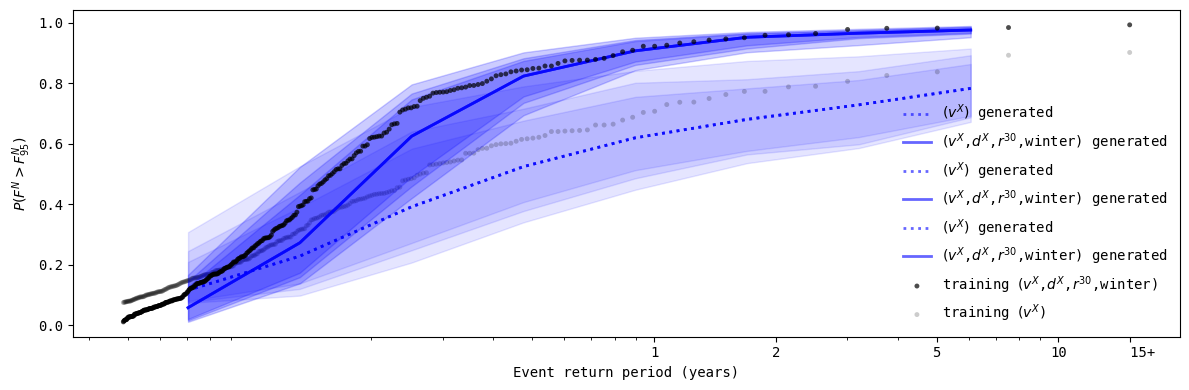

In [51]:
def plot_intervals(ds, ax, num_bins=50, color="k", label="", alpha=0.05, interval=True):
    df = ds.to_dataframe().reset_index()
    bins = np.logspace(np.log10(df['return_period'].min()), 
                       np.log10(df['return_period'].max()), 
                       num=num_bins)
    
    df['return_period_binned'] = pd.cut(df['return_period'], bins=bins)
    df['return_period_center'] = df['return_period_binned'].apply(lambda x: x.mid)
    
    quartiles = df.groupby('return_period_center').agg({
        'outage_prob': ['median', lambda x: x.quantile(alpha), lambda x: x.quantile(1-alpha)],
        'base_probs': ['median', lambda x: x.quantile(alpha), lambda x: x.quantile(1-alpha)]
    }).reset_index()
    

    quartiles.columns = ['return_period', 
                         'outage_median', 'outage_q25', 'outage_q75',
                         'base_median', 'base_q25', 'base_q75']
    
    quartiles = quartiles.dropna()
    
    # Plot the base data (grey) with IQR
    if interval:
        ax.fill_between(quartiles['return_period'], 
                        quartiles['base_q25'], 
                        quartiles['base_q75'],
                        color=color, alpha=0.1, zorder=0)
    ax.plot(quartiles['return_period'], quartiles['base_median'], 
            color=color, alpha=0.6, linewidth=2, linestyle="dotted", label=rf"$(v^X)${label}", zorder=0)
    
    # Plot the full data (black) with IQR
    if interval:
        ax.fill_between(quartiles['return_period'], 
                        quartiles['outage_q25'], 
                        quartiles['outage_q75'],
                        color=color, alpha=0.2, zorder=1)
    ax.plot(quartiles['return_period'], quartiles['outage_median'], 
            color=color, alpha=0.6, linewidth=2, 
            label=fr"$(v^X$,$d^X$,$r^{{30}}$,{season}){label}", zorder=1)


fig.suptitle(f"{region_of_interest}\n{gen_ensembles}x{ensemble_years}-year ensembles", y=1.05);

fig, ax = plt.subplots(figsize=(12,4))

# plot_intervals(training, ax, color="k", num_bins=50, label=" reanalysis", interval=True)
plot_intervals(generated, ax, color="blue", num_bins=10, alpha=0.01, label=" generated")
plot_intervals(generated, ax, color="blue", num_bins=10, alpha=0.05, label=" generated")
plot_intervals(generated, ax, color="blue", num_bins=10, alpha=0.1, label=" generated")


# generated.plot.scatter(x="return_period", y="outage_prob", ax=ax, color="blue", edgecolor='none',
#                       s=50, alpha=0.7, marker='.', zorder=1, label=fr"training $(v^X$,$d^X$,$r^{{30}}$,{season})")
# generated.plot.scatter(x="base_return_period", y="base_probs", ax=ax, color="blue", edgecolor='none',
#                       s=50, alpha=0.2, marker='.', zorder=0, label=r"training $(v^X$)")


training.plot.scatter(x="return_period", y="outage_prob", ax=ax, color="k", edgecolor='none',
                      s=50, alpha=0.7, marker='.', zorder=1, label=fr"training $(v^X$,$d^X$,$r^{{30}}$,{season})")
training.plot.scatter(x="base_return_period", y="base_probs", ax=ax, color="k", edgecolor='none',
                      s=50, alpha=0.2, marker='.', zorder=0, label=r"training $(v^X$)")

ax.set_title("")
ax.set_xscale("log")
ticks = [1, 2, 5, 10, 20, 50, 100, 250, 500, 1000]
ticks = [t for t in ticks if t <= rp_max]
ax.set_xticks(ticks + [rp_max], labels=ticks + [f"   {rp_max:.0f}+"])
ax.set_ylabel(r"$P(F^N>F^N_{95})$")
ax.set_xlabel("Event return period (years)")
ax.legend(loc="lower right", frameon=False)
fig.tight_layout()
# ax.set_yscale("logit")